In [1]:
import os
from PIL import Image

import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py
import pickle

from torchvision import transforms
from medicaltorch import datasets as mt_datasets
from medicaltorch import transforms as mt_transforms

from src.dataset import MRI2DSegmentationDataset
from src.config import directories

data_dir = directories['lits']

# Data Summary

In [3]:
data_dir = os.path.join(data_dir, 'media', 'nas', '01_Datasets', 'CT', 'LITS')
data_train_dir = os.path.join(data_dir, 'Training Set')
data_test_dir = os.path.join(data_dir, 'Testing Set')

volume_filepaths = [os.path.join(data_train_dir, name) for name in sorted(os.listdir(data_train_dir)) 
                    if 'volume' in name]
segmentation_filepaths = [os.path.join(data_train_dir, name) for name in sorted(os.listdir(data_train_dir)) 
                          if 'segmentation' in name]

pairs = [(vol, gt) for vol, gt in zip(volume_filepaths, segmentation_filepaths)]
train_dataset = MRI2DSegmentationDataset(pairs, cache=False)

Number of slices: 58638
Input Image
    Dtype: float32
    Shape: (512, 512)
    Unique Values: [-3024. -1024. -1023. ...  1161.  1168.  1181.]
    
Ground Truth
    Dtype: float32
    Shape: (512, 512)
    Unique Labels: [0. 1. 2.]
        0: Background
        1: Liver
        2: Tumor



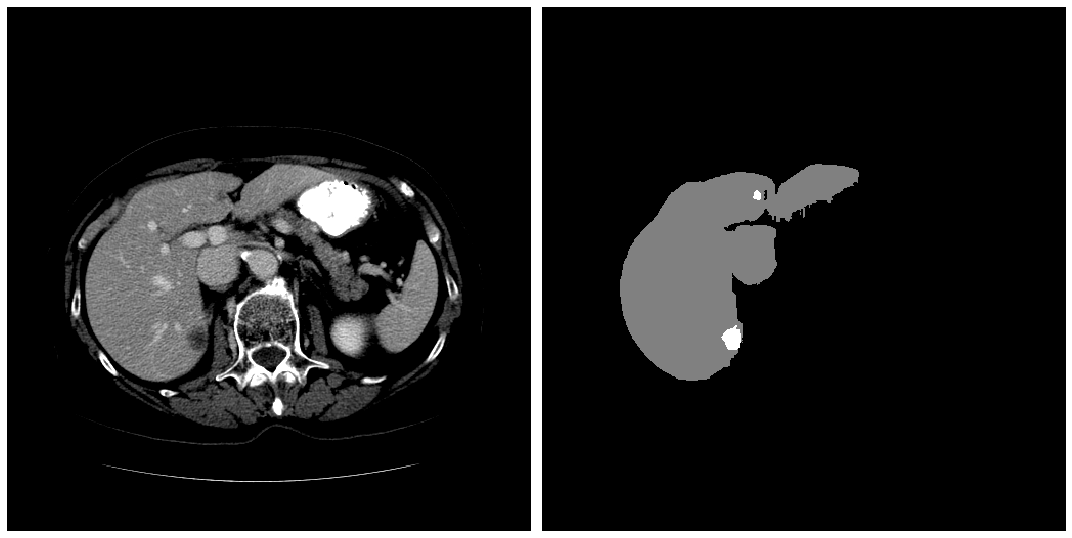

In [4]:
idx = 57
image, target = train_dataset[idx]

print(f"""Number of slices: {len(train_dataset)}
Input Image
    Dtype: {np.array(image).dtype}
    Shape: {image.size}
    Unique Values: {np.unique(np.array(image))}
    
Ground Truth
    Dtype: {np.array(target).dtype}
    Shape: {target.size}
    Unique Labels: {np.unique(np.array(target))}
        0: Background
        1: Liver
        2: Tumor
""")

image, target = image.convert('RGB'), target.convert('L')

image = np.rot90(np.array(image), k=1)
target = np.rot90(np.array(target), k=1)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 15))
ax1.imshow(image, cmap="gray")
ax1.axis('off')

ax2.imshow(target, cmap="gray")
ax2.axis('off')
plt.show()

[0.]


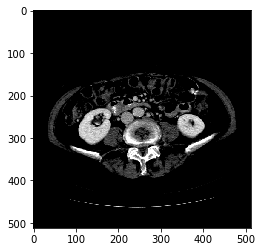

In [17]:
image, target = train_dataset[41]
print(np.unique(target))

image = np.rot90(np.array(image), k=1)
image = Image.fromarray(image).convert('RGB')

plt.imshow(image)

In [18]:
image.save('CompositionalNets/background_images/ct_slice_general.JPEG')

# Filter for Slices that Contain Livers or Tumors and Create HDF5 File

1. Filter out any slices that don't contain liver pixels. We don't want to train on images which only consist of "background" pixels;
2. We rotate filtered slices so that the liver is situated on the left and upstraight. That way the orientation of the livers is the same as in the CHAOS dataset;
3. Save the images into an HDF5 file so that it can be used later for training.

In [4]:
hdf5_path = os.path.join(data_dir, 'train.hdf5')
hf = h5py.File(hdf5_path, 'w')
image_dset = hf.create_dataset('images', (1, 512, 512), maxshape=(None, 512, 512))
target_dset = hf.create_dataset('masks', (1, 512, 512), maxshape=(None, 512, 512))

i = 0
for data in tqdm(train_dataset):
    image, target = data
    if np.any(np.isin((1,2), np.array(target))):
        image = np.asarray(image, dtype=np.float32)
        image = np.rot90(image, k=1)
        
        target = np.asarray(target, dtype=np.float32)
        target = np.rot90(target, k=1)
        
        image_dset[i] = image
        target_dset[i] = target
        
        i += 1
        image_dset.resize((i+1, 512, 512))
        target_dset.resize((i+1, 512, 512))
hf.close()

100%|██████████| 58638/58638 [21:19<00:00, 45.83it/s] 


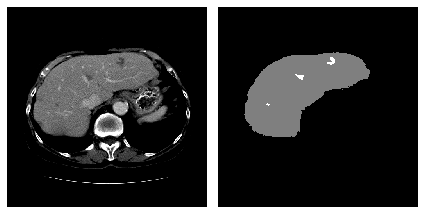

In [6]:
hf = h5py.File(hdf5_path, 'r')
image = Image.fromarray(hf['images'][50], mode='F')
target = Image.fromarray(hf['masks'][50]*255//2, mode='F')

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True)
ax1.imshow(image, cmap="gray")
ax1.axis('off')

ax2.imshow(target, cmap="gray")
ax2.axis('off')
plt.show()
hf.close()

# Labels Distribution

In [7]:
from collections import Counter

In [10]:
hdf5_path = os.path.join(data_dir, 'train.hdf5')
hf = h5py.File(hdf5_path, 'r+')
target_dset = hf['masks']

In [9]:
counts = Counter(target_dset[:,:,:].reshape(-1))
arr_counts = np.array([counts[0.0], counts[1.0], counts[2.0]])

arr_counts = arr_counts.astype(np.float64)
ratios = np.copy(arr_counts)
arr_sum = sum(arr)
for i, e in enumerate(ratios):
    ratios[i] = e / arr_sum

In [65]:
arr_counts

array([4.67249793e+09, 3.32764489e+08, 1.84651940e+07])

In [17]:
ratios

array([0.93008584, 0.06623856, 0.0036756 ])

In [ ]:
hf.create_dataset('target_count', data=counts)
hf.create_dataset('target_ratios', data=ratios)
hf.close()

# Create Background Images

In [3]:
hdf5_path = os.path.join(data_dir, 'train.hdf5')
hf = h5py.File(hdf5_path, 'r+')
target_dset = hf['masks']

In [4]:
image_dset = hf['images']

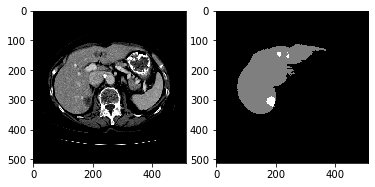

In [51]:
idx = 42
plt.subplot(1, 2, 1)
im1 = Image.fromarray(image_dset[idx], mode='F').convert('RGB')
plt.imshow(im1)
plt.subplot(1, 2, 2)
im2 = Image.fromarray(target_dset[idx]*255//2, mode='F').convert('RGB')
plt.imshow(im2)
plt.show()

In [52]:
im1.save('CompositionalNets/background_images/liver_noise.JPEG')

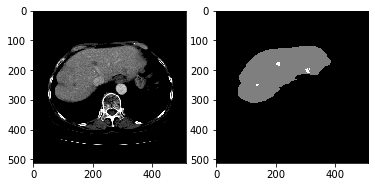

In [53]:
idx = 52
plt.subplot(1, 2, 1)
im1 = Image.fromarray(image_dset[idx], mode='F').convert('RGB')
plt.imshow(im1)
plt.subplot(1, 2, 2)
im2 = Image.fromarray(target_dset[idx]*255//2, mode='F').convert('RGB')
plt.imshow(im2)
plt.show()

In [54]:
im1.save('CompositionalNets/background_images/liver2_noise.JPEG')

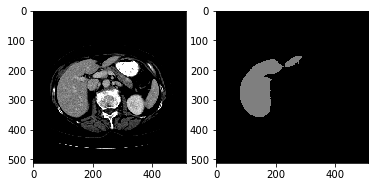

In [55]:
idx = 10
plt.subplot(1, 2, 1)
im1 = Image.fromarray(image_dset[idx], mode='F').convert('RGB')
plt.imshow(im1)
plt.subplot(1, 2, 2)
im2 = Image.fromarray(target_dset[idx]*255//2, mode='F').convert('RGB')
plt.imshow(im2)
plt.show()

In [56]:
im1.save('CompositionalNets/background_images/liver_general.JPEG')

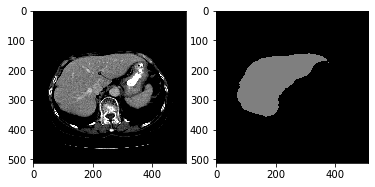

In [57]:
idx = 19
plt.subplot(1, 2, 1)
im1 = Image.fromarray(image_dset[idx], mode='F').convert('RGB')
plt.imshow(im1)
plt.subplot(1, 2, 2)
im2 = Image.fromarray(target_dset[idx]*255//2, mode='F').convert('RGB')
plt.imshow(im2)
plt.show()

In [58]:
im1.save('CompositionalNets/background_images/liver2_general.JPEG')

# Grid View of Slices

In [33]:
def show_slices(slices, figsize=(15, 15), subplots=None):
    """ Function to display row of image slices """
    if subplots:
        fig, axes = plt.subplots(subplots[0], subplots[1], figsize=figsize)
        for sub_axes in axes:
            for axe in sub_axes:
                s = slices.pop()
                axe.imshow(s.T, cmap="gray", origin="lower")
    else:
        fig, axes = plt.subplots(1, len(slices), figsize=figsize)
        for i, s in enumerate(slices):
            axes[i].imshow(s.T, cmap="gray", origin="lower")

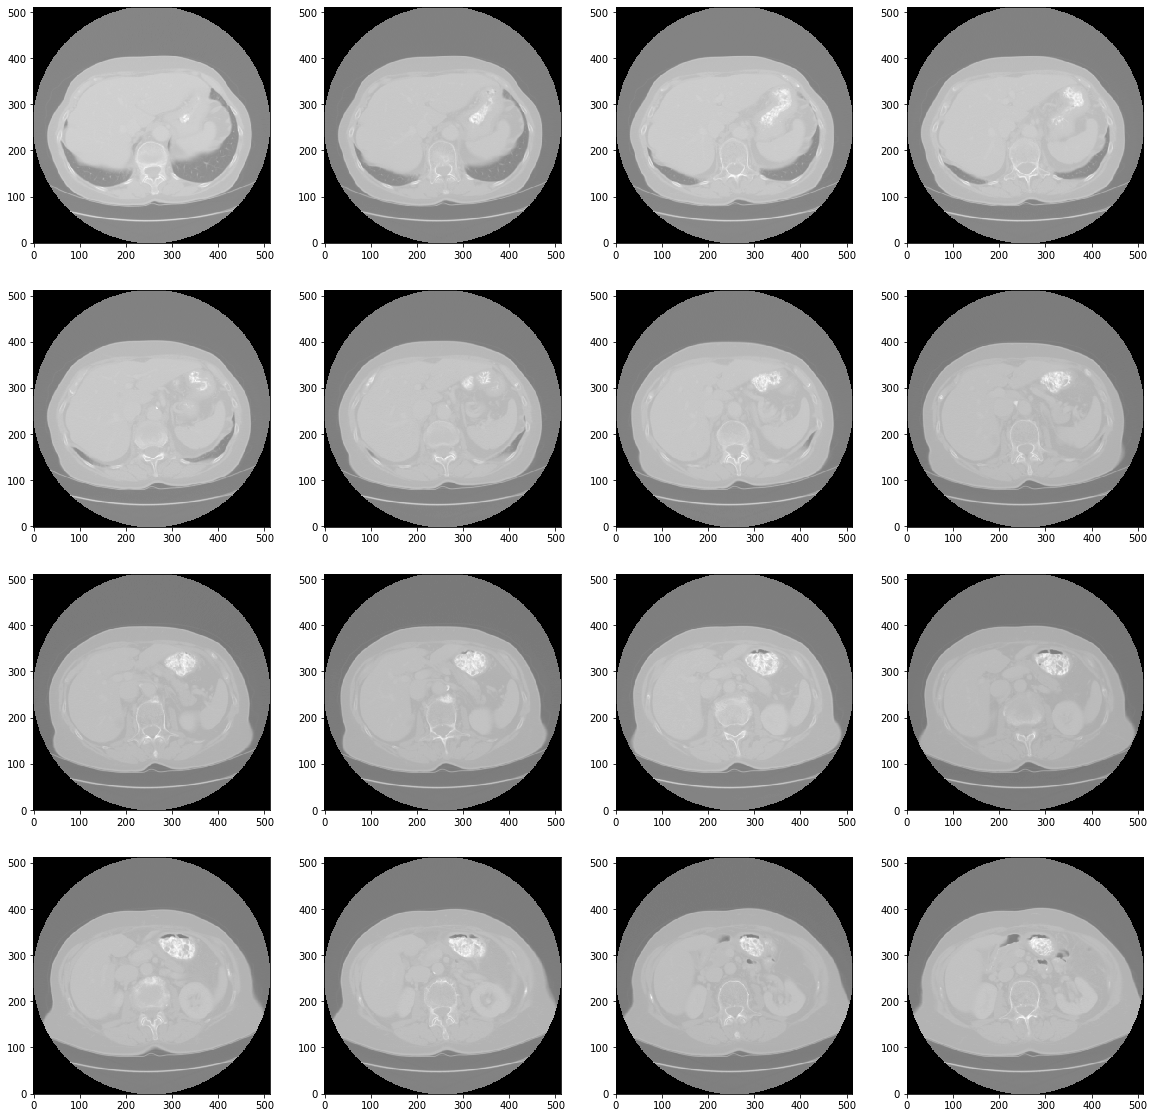

In [34]:
volume = nib.load(volume_filepaths[0])
volume_data = volume.get_fdata('unchanged')

x, y = (4, 4)
start = int(volume_data.shape[2]//1.5)
slices = [volume_data[:, :, s] for s in range(start,  start + x * y)]
show_slices(slices, figsize=(20, 20), subplots=(x, y))

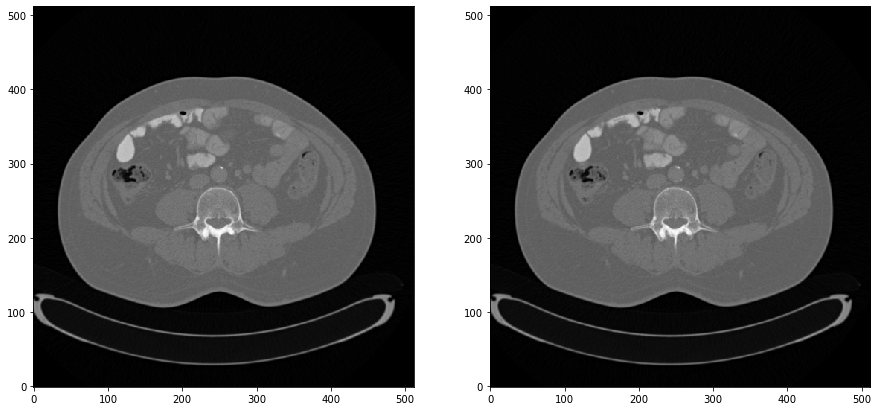

In [79]:
# for all top-down view slices
# slices = [volume_data[:, :, s] for s in range(volume_data.shape[2])]

slices = [volume_data[:, :, s] for s in range(volume_data.shape[2]//2,  volume_data.shape[2]//2 + 2)]
show_slices(slices, subplots=(5, 5))

# Apply CT Abdomen Filter

In [23]:
volume = nib.nifti1.load(volume_filepaths[0])

In [24]:
volume

In [42]:
image = volume.dataobj[...,60]

In [43]:
L = 40
W = 350
# image = images[0]
image[image < (L-(W//2))] = L - (W//2)
image[image > (L+(W//2))] = L + (W//2)

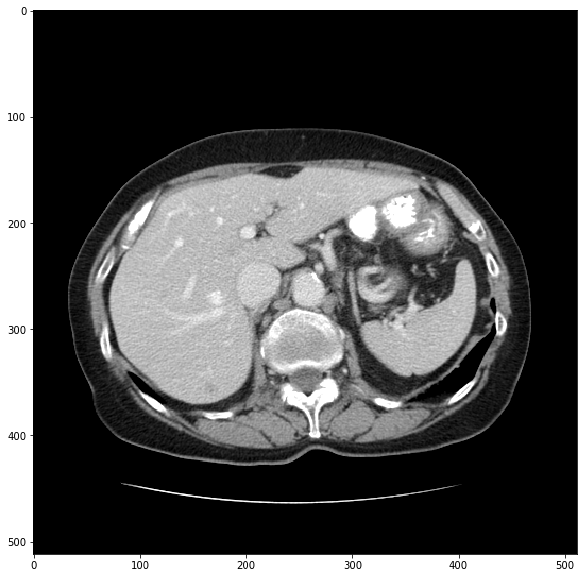

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(np.rot90(image), cmap='gray')